# <u>IMPORTS

In [1]:
import numpy as np 
from scipy.integrate import solve_ivp
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
import sys

# <u>TESTING PARAMETERS

In [2]:
# set common paramaters between tests
duration = 10 # seconds
sampling_rate = 1000 # hertz
no_samples = int(duration/(1/sampling_rate))
t = np.linspace(0, duration ,no_samples)
weight = 3.5

# <u>FUNCTIONS

## NOISE

In [3]:
def addNoise(sig):    
    mean = 0
    std_dev = 1
    noise = np.random.normal(mean, std_dev, len(sig))
    return sig + noise

## CONSTANT WEIGHT

In [4]:
def constantWeight(t,w, time_before = 0):
    # get the sampling period
    signal = np.full_like(t, w*9.8)
    return signal

## CREATE DAMPED OSCILATION

#### FUNCTION

In [5]:
def DampOscilation(t,gamma,omega_sqr):
    # gamma sets how long it takes for oscilations to dampen
    # omega squared changes how quickly the oscilations disapear

    y = [0,1]
    def sho(t,y):
        solution = (y[1],(-gamma*y[1]-omega_sqr*y[0]))
        return solution
    solution = solve_ivp(sho, [0,t.size], y0 = y, t_eval = t)

    # scale the oscilation so the max value is 1
    osc = solution.y[0]
    osc = osc * 1/np.max(osc)

    return osc

#### EXAMPLE

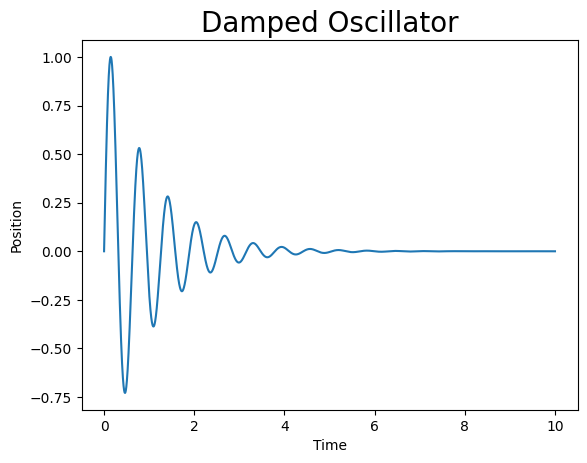

In [6]:
# generate oscillation
osc = DampOscilation(t,2,100)

# plot
plt.plot(t,osc)
plt.ylabel("Position")
plt.xlabel("Time")
plt.title('Damped Oscillator', fontsize = 20)
plt.show()

## LANDING

#### FUNCTION

In [7]:
def Landing(t,start_time):
    # System parameters
    damping_ratio = 0.4  # alters the rate of damping
    natural_frequency = 6  # alters the frequency of oscilations

    # create transfer function for second order underdamped system
    numerator = [natural_frequency**2]
    denominator = [1, 2*damping_ratio*natural_frequency, natural_frequency**2]
    system = signal.TransferFunction(numerator, denominator)

    # calculate landing time
    if start_time > t[t.size-1]:
        print("Start time is outside signal time.")
        sys.exit()
    start_index = np.abs(t - start_time).argmin()
    no_samples = int(t.size - start_index)
    t_osc = np.linspace(t[start_index], t[t.size-1],no_samples)

    # compute the step response
    time, osc = signal.step(system, T=t_osc)

    # zero pad the beginning of the oscilation
    osc = np.pad(osc, (start_index, 0), mode='constant')

    return osc

#### EXAMPLE

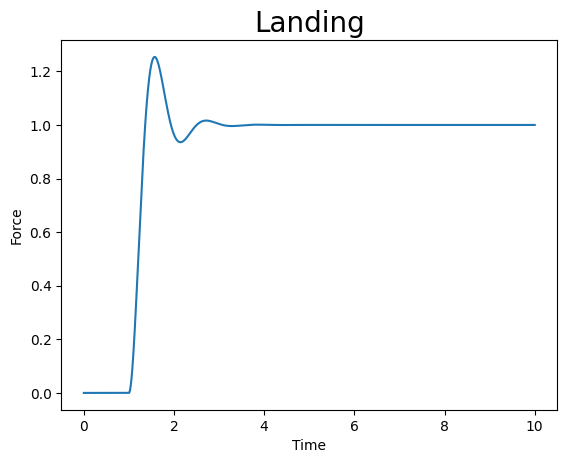

In [8]:
# generate landing example
landing = Landing(t,1)

plt.plot(t,landing)
plt.ylabel("Force")
plt.xlabel("Time")
plt.title('Landing', fontsize = 20)
plt.show()

## TAKE-OFF

#### FUNCTION

In [9]:
def TakeOff(t):
    # System parameters
    damping_ratio = 0.3  # alters the rate of damping
    natural_frequency = 10  # alters the frequency of oscilations

    # create transfer function for second order underdamped system
    numerator = [natural_frequency**2]
    denominator = [1, 2*damping_ratio*natural_frequency, natural_frequency**2]
    system = signal.TransferFunction(numerator, denominator)

    # compute the step response
    time, osc = signal.step(system, T=t)

    # invert oscilation
    osc = osc[::-1]

    return osc

#### EXAMPLE

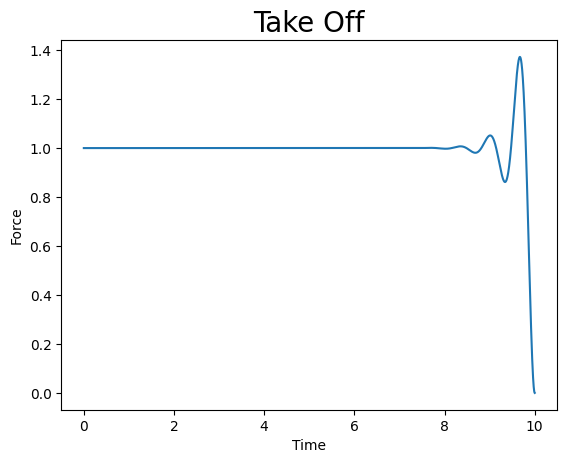

In [10]:
# generate landing example
take_off = TakeOff(t)
plt.plot(t,take_off)
plt.ylabel("Force")
plt.xlabel("Time")
plt.title('Take Off', fontsize = 20)
plt.show()

### WALKING

In [11]:
def Step(samp_per,step_dur):
    t_step = np.linspace(0, step_dur, m.ceil(step_dur/samp_per) + 1)

    outer_freq = 1/(2*step_dur)
    outer_sig =  np.sin(2 * np.pi * outer_freq * t_step)

    base_freq = 5 * outer_freq
    base_sig = np.sin(2 * np.pi * base_freq * t_step)

    step = outer_sig * base_sig

    return step * -1

def addSteps(t,f,step_times,step_dur,weight,weight_perc):
    samp_per = t[1] - t[0]
    for step_time in step_times:
        step = Step(samp_per,step_dur) * weight * weight_perc * 9.8
        start_index = int(step_time/samp_per)
        end_index = start_index + int(step_dur/samp_per)
        for i in range(start_index,end_index):
            f[i] = f[i] + step[i-start_index]

    return f

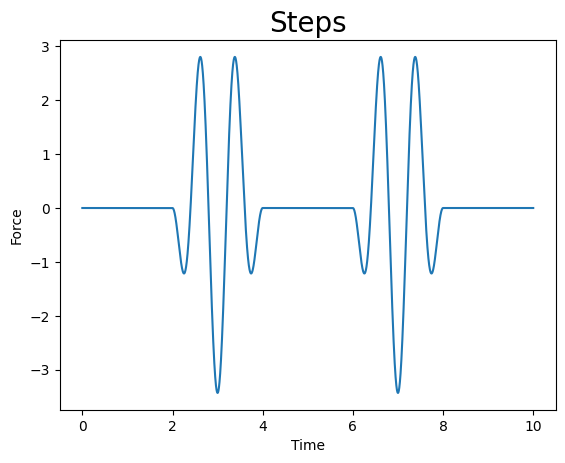

In [12]:
# generate walking
weight_force = constantWeight(t,0)
steps = addSteps(t,weight_force,[2,6],2,weight,0.1)
plt.plot(t,steps)
plt.ylabel("Force")
plt.xlabel("Time")
plt.title('Steps', fontsize = 20)
plt.show()

## ALL TOGETHER

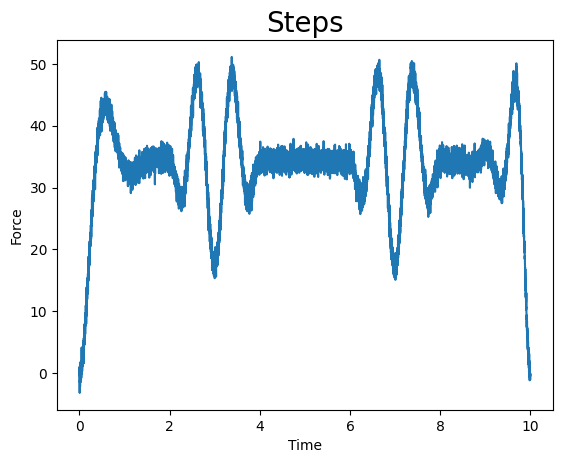

In [14]:
# generate walking
sim = Landing(t,0)
sim = sim * TakeOff(t) * weight * 9.8
sim = addSteps(t,sim,[2,6],2,weight,0.5)
sim = addNoise(sim)
plt.plot(t,sim)
plt.ylabel("Force")
plt.xlabel("Time")
plt.title('Steps', fontsize = 20)
plt.show()